In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import torch
import torch.nn as nn

In [3]:
import os
os.environ['METALHOME'] = '/Users/vincentchen/code/metal'

In [4]:
from metal.mmtl.data import MmtlDataLoader, MmtlDataset
from metal.mmtl.metal_model import MetalModel
from metal.mmtl.slicing.slice_model import SliceModel
from metal.mmtl.payload import Payload
from metal.mmtl.task import ClassificationTask
from metal.mmtl.slicing.slicing_tasks import BinaryClassificationTask
from metal.mmtl.trainer import MultitaskTrainer
from metal.utils import split_data

In [5]:
import matplotlib.pyplot as plt

## Create Tasks and Payloads
Initializes appropriate slice labelsets/slice heads

In [6]:
from functools import partial

def get_circle_idx(X, center, radius):
    h, k = center
    idx = np.sqrt((X[:, 0] - h) ** 2 + (X[:, 1] - k) ** 2) < radius
    return idx

circle_fn_1 = partial(get_circle_idx, center=(0.0, 0.0), radius=0.5)
circle_fn_2 = partial(get_circle_idx, center=(0.5, 0.2), radius=0.3)
identity_fn = lambda x: torch.from_numpy(np.ones(x.shape[0], dtype=np.uint8))

In [7]:
from metal.mmtl.slicing.slicing import create_slice_task

def create_tasks(task_name, slice_names=[]):
    input_module = nn.Linear(2, 8)
    head_module = nn.Linear(8, 1) # NOTE: slice_model requires 1dim task head    
    task = BinaryClassificationTask(
        name=task_name, input_module=input_module, head_module=head_module
    )
    tasks = [task]

    for slice_name in slice_names:
        slice_task_name = f"{task_name}:{slice_name}"
        slice_task = create_slice_task(task, slice_task_name)
        tasks.append(slice_task)
    
    return tasks

def create_payloads(task_name, N, batch_size=1, slice_funcs={}):
    payloads = []
    
    uids = list(range(N))
    X = np.random.random((N, 2)) * 2 - 1
    Y = (X[:, 0] > X[:, 1] + 0.25).astype(int) + 1

    uids = torch.tensor(uids, dtype=torch.long)
    X = torch.tensor(X, dtype=torch.float)
    Y = torch.tensor(Y, dtype=torch.long)

    uid_lists, Xs, Ys = split_data(uids, X, Y, splits=[0.8, 0.1, 0.1], shuffle=True)

    labels_to_tasks = {"labelset_gold": task_name}
    for i, split in enumerate(SPLITS):
        payload_name = f"payload_{split}"
        X_dict = {"data": Xs[i], "uids": uid_lists[i]}
        Y_dict = {"labelset_gold": Ys[i]}

        if slice_funcs:
            for slice_name, slice_fn in slice_funcs.items():
                slice_mask = slice_fn(Xs[i])
                slice_labels = Ys[i].clone().detach()
                slice_labels[np.logical_not(slice_mask)] = 0
                slice_task_name = f"labelset:{slice_name}"
                Y_dict[slice_task_name] = torch.tensor(slice_labels, dtype=torch.long)
                labels_to_tasks[slice_task_name] = f"{task_name}:{slice_name}"

        dataset = MmtlDataset(X_dict, Y_dict)
        data_loader = MmtlDataLoader(dataset, batch_size=batch_size)
        payload = Payload(payload_name, data_loader, labels_to_tasks, split)
        payloads.append(payload)
        
    return payloads

In [8]:
N = 1000
T = 1
SPLITS = ["train", "valid", "test"]
slice_funcs = {"circle1": circle_fn_1, "circle2": circle_fn_2, "BASE": identity_fn}
task_name = "test_task"

In [9]:
tasks = create_tasks(task_name, slice_names=list(slice_funcs.keys()))
tasks

[BinaryClassificationTask(name=test_task, loss_multiplier=1.00, is_slice=False),
 BinaryClassificationTask(name=test_task:circle1, loss_multiplier=1.00, is_slice=True),
 BinaryClassificationTask(name=test_task:circle2, loss_multiplier=1.00, is_slice=True),
 BinaryClassificationTask(name=test_task:BASE, loss_multiplier=1.00, is_slice=True)]

In [10]:
payloads = create_payloads(task_name, N, batch_size=4, slice_funcs=slice_funcs)
payloads

/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Payload(payload_train: labels_to_tasks=[{'labelset_gold': 'test_task', 'labelset:circle1': 'test_task:circle1', 'labelset:circle2': 'test_task:circle2', 'labelset:BASE': 'test_task:BASE'}], split=train),
 Payload(payload_valid: labels_to_tasks=[{'labelset_gold': 'test_task', 'labelset:circle1': 'test_task:circle1', 'labelset:circle2': 'test_task:circle2', 'labelset:BASE': 'test_task:BASE'}], split=valid),
 Payload(payload_test: labels_to_tasks=[{'labelset_gold': 'test_task', 'labelset:circle1': 'test_task:circle1', 'labelset:circle2': 'test_task:circle2', 'labelset:BASE': 'test_task:BASE'}], split=test)]

payload_train labelset_gold


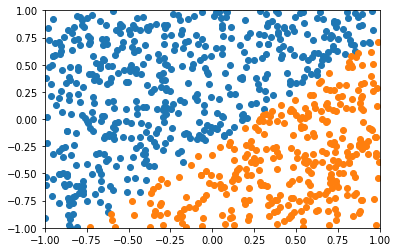

payload_train labelset:circle1


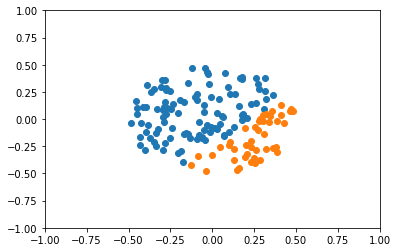

payload_train labelset:circle2


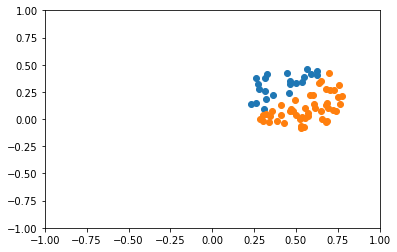

payload_train labelset:BASE


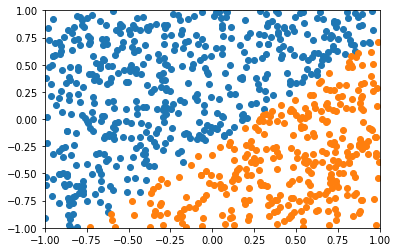

payload_valid labelset_gold


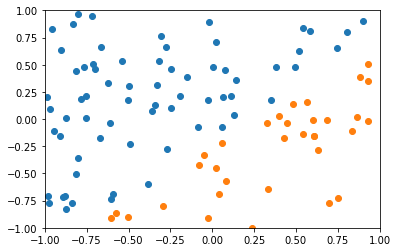

payload_valid labelset:circle1


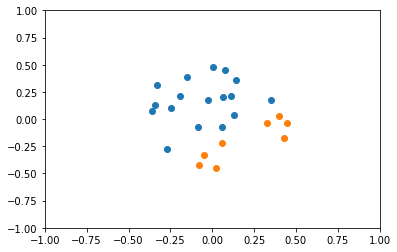

payload_valid labelset:circle2


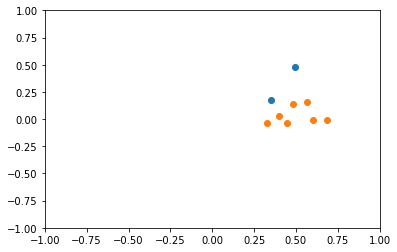

payload_valid labelset:BASE


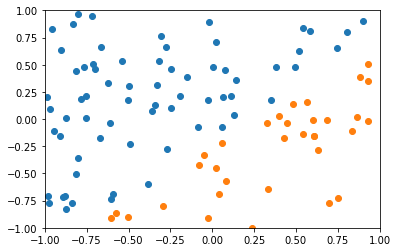

payload_test labelset_gold


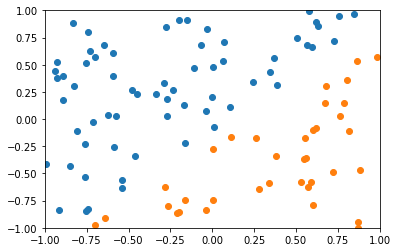

payload_test labelset:circle1


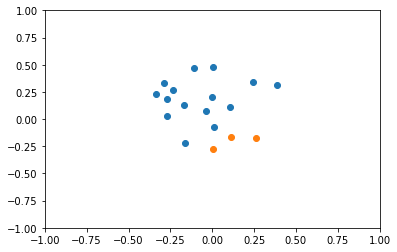

payload_test labelset:circle2


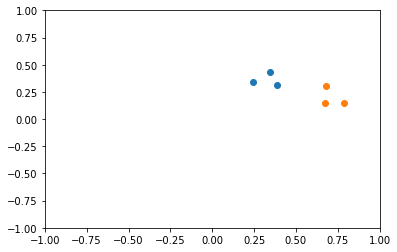

payload_test labelset:BASE


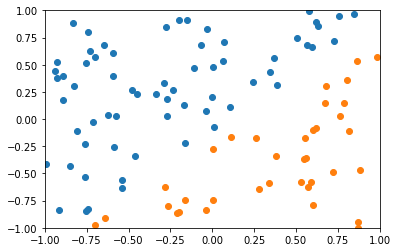

In [11]:
def plot_data(X, preds, gt=None):
    if gt is not None:
        correct_mask = preds == gt
        incorrect_mask = preds != gt
        plt.scatter(X[correct_mask, 0], X[correct_mask, 1], c='green')
        plt.scatter(X[incorrect_mask, 0], X[incorrect_mask, 1], c='red')
        
    else:
        Y1_mask = preds == 1
        Y2_mask = preds == 2
        plt.scatter(X[Y1_mask, 0], X[Y1_mask, 1])
        plt.scatter(X[Y2_mask, 0], X[Y2_mask, 1])

    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.show()

for p in payloads:
    X = np.array(p.data_loader.dataset.X_dict['data'])
    labelsets = p.data_loader.dataset.Y_dict
    for label_name, labels in labelsets.items():
        print(p.name, label_name)
        Y = labels.numpy()
        plot_data(X, Y)

In [12]:
model = SliceModel(tasks, verbose=False)
# model = MetalModel(tasks, verbose=False)
model

SliceModel(
  (input_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): Linear(in_features=2, out_features=8, bias=True)
      )
    )
    (test_task:BASE): DataParallel(
      (module): MetalModuleWrapper(
        (module): Linear(in_features=2, out_features=8, bias=True)
      )
    )
    (test_task:circle1): DataParallel(
      (module): MetalModuleWrapper(
        (module): Linear(in_features=2, out_features=8, bias=True)
      )
    )
    (test_task:circle2): DataParallel(
      (module): MetalModuleWrapper(
        (module): Linear(in_features=2, out_features=8, bias=True)
      )
    )
  )
  (middle_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): IdentityModule()
      )
    )
    (test_task:BASE): DataParallel(
      (module): MetalModuleWrapper(
        (module): IdentityModule()
      )
    )
    (test_task:circle1): DataParallel(
      (module): MetalModuleWrapp

In [13]:
trainer = MultitaskTrainer(verbose=False, lr=0.005)

In [14]:
metrics_dict = trainer.train_model(
    model, payloads, verbose=True,
    n_epochs=10
)

Beginning train loop.
Expecting a total of approximately 800 examples and 200 batches per epoch from 1 payload(s) in the train split.


/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1.0 epo]: test_task:[payload_train/labelset_gold/loss=4.05e-01, payload_valid/labelset_gold/accuracy=1.00e+00] test_task:circle1:[payload_train/labelset:circle1/loss=1.58e-01, payload_valid/labelset:circle1/accuracy=9.20e-01] test_task:circle2:[payload_train/labelset:circle2/loss=1.76e-01, payload_valid/labelset:circle2/accuracy=8.89e-01] test_task:BASE:[payload_train/labelset:BASE/loss=9.80e-02, payload_valid/labelset:BASE/accuracy=1.00e+00] model:[train/all/loss=2.41e-01, train/all/lr=5.00e-03]
[2.0 epo]: test_task:[payload_train/labelset_gold/loss=8.77e-02, payload_valid/labelset_gold/accuracy=9.90e-01] test_task:circle1:[payload_train/labelset:circle1/loss=7.64e-02, payload_valid/labelset:circle1/accuracy=9.60e-01] test_task:circle2:[payload_train/labelset:circle2/loss=1.16e-01, payload_valid/labelset:circle2/accuracy=8.89e-01] test_task:BASE:[payload_train/labelset:BASE/loss=2.80e-02, payload_valid/labelset:BASE/accuracy=1.00e+00] model:[train/all/loss=6.16e-02, train/all/lr=5.00

### Ensure that test set runs on slices

In [15]:
import copy
eval_payload = copy.deepcopy(payloads[2])

# NOTE: we need to retarget slices to the original RTE head
for label_name in ["labelset:circle1", "labelset:circle2"]:
    eval_payload.retarget_labelset(label_name, 'test_task')

label_set labelset:circle1 now points to task test_task (originally, test_task:circle1).
label_set labelset:circle2 now points to task test_task (originally, test_task:circle2).


In [16]:
model.score(eval_payload)

{'test_task/payload_test/labelset_gold/accuracy': 1.0,
 'test_task/payload_test/labelset:circle1/accuracy': 1.0,
 'test_task/payload_test/labelset:circle2/accuracy': 1.0,
 'test_task:BASE/payload_test/labelset:BASE/accuracy': 1.0}

Evaluate a specific main task head on separate labelsets

In [18]:
target_tasks = list(eval_payload.labels_to_tasks.values())
target_labels = list(eval_payload.labels_to_tasks.keys())
Ys, Ys_probs, Ys_preds = model.predict_with_gold(eval_payload, target_tasks, target_labels, return_preds=True)

### Visualize Predictions

labelset_gold


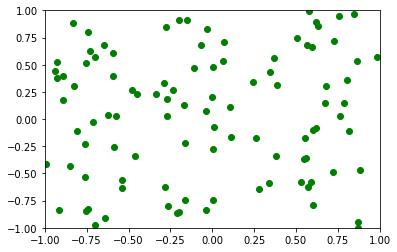

labelset:circle1


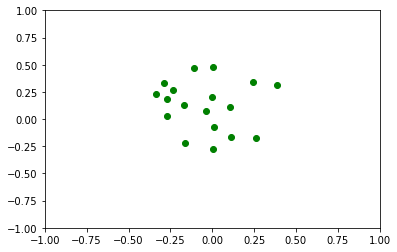

labelset:circle2


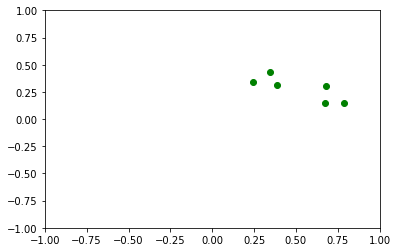

labelset:BASE


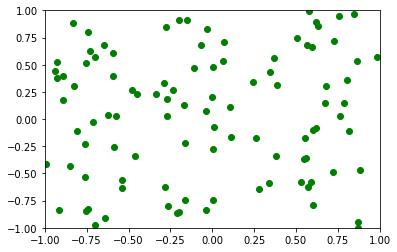

In [19]:
X = np.array(eval_payload.data_loader.dataset.X_dict['data'])
for label_name, task_name in eval_payload.labels_to_tasks.items():
    print(label_name)
    Y = np.array(Ys[label_name]).squeeze()
    preds = np.array(Ys_preds[task_name]).squeeze()

    slice_mask = Y != 0
    X_slice = X[slice_mask, :]
    pred_slice = preds[slice_mask]
    gt_slice = Y[slice_mask]
    plot_data(X_slice, pred_slice, gt_slice)